## Linear Regression Examples

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from interval import interval
from itertools import product
from scipy.spatial import ConvexHull
from scipy.stats import t

In [3]:
class Zonotope:
    def __init__(self, centre, generators):
        self.centre = np.array(centre).reshape(-1)
        self.generators = np.atleast_2d(generators)  
        if self.generators.shape[0] != self.centre.shape[0]:
            raise ValueError("Generators must have same dimension as centre")
        self.n = self.centre.shape[0]   # dimension
        self.m = self.generators.shape[1]  # number of generators

    def minkowski_sum(self, other):
        new_centre = self.centre + other.centre
        new_generators = np.hstack((self.generators, other.generators))
        return Zonotope(new_centre, new_generators)
    
    def output_interval(self):
        radius = np.sum(np.abs(self.generators), axis=1)  # sum across generators
        lower = self.centre - radius
        upper = self.centre + radius
        return lower, upper

    def affine_map(self, A, b=None):
        new_centre = A @ self.centre + (b if b is not None else 0)
        new_generators = A @ self.generators 
        return Zonotope(new_centre, new_generators)

### Data and Regression Functions

In [4]:
def naive_bounds(X, y_lower, y_upper, x_grid=None):
    M = np.linalg.inv(X.T @ X) @ X.T 
    y_intervals = [interval[y_l, y_u] for y_l, y_u in zip(y_lower, y_upper)]

    beta_naive = []
    for i in range(M.shape[0]):
        row = M[i]
        beta_j = interval[0, 0]
        for c, y_int in zip(row, y_intervals):
            beta_j += float(c) * y_int
        beta_naive.append(beta_j)

    if x_grid is not None:
        beta0, beta1 = beta_naive
        y_min = []
        y_max = []
        for xg in x_grid:
            y_int = beta0 + beta1 * xg
            y_min.append(y_int[0][0])
            y_max.append(y_int[0][1])
        return beta_naive, (np.array(y_min), np.array(y_max))
    
    return beta_naive

def actual_bounds(X, y_lower, y_upper, x_grid=None):
    M = np.linalg.inv(X.T @ X) @ X.T

    vertices = list(product(*zip(y_lower, y_upper)))
    beta_vertices = []
    for y_vertex in vertices:
        y_vertex = np.array(y_vertex)
        beta_vertex = M @ y_vertex
        beta_vertices.append(beta_vertex)

    if x_grid is not None:
        y_min, y_max = [], []
        for xg in x_grid:
            preds = [b[0] + b[1] * xg for b in beta_vertices]
            y_min.append(min(preds))
            y_max.append(max(preds))
        return beta_vertices, (np.array(y_min), np.array(y_max))
    
    return beta_vertices

def monte_carlo_sampling(X, y_lower, y_upper, n_samples=10000, x_grid=None):
    y_lower = np.array(y_lower, dtype=float)
    y_upper = np.array(y_upper, dtype=float)
    
    M = np.linalg.inv(X.T @ X) @ X.T
    n_points = len(y_lower)
    
    rng = np.random.default_rng()
    y_samples = rng.uniform(low=y_lower, high=y_upper, size=(n_samples, n_points))
    
    beta_samples = (M @ y_samples.T).T
    
    if x_grid is not None:
        x_grid = np.array(x_grid, dtype=float)
        preds = beta_samples[:, 0][:, np.newaxis] + beta_samples[:, 1][:, np.newaxis] * x_grid[np.newaxis, :]
        y_min = np.min(preds, axis=0)
        y_max = np.max(preds, axis=0)
        return beta_samples, (y_min, y_max)
    
    return beta_samples


def zonotope_bounds(X, y_lower, y_upper, x_grid=None):
    M = np.linalg.inv(X.T @ X) @ X.T

    centre_y = (y_lower + y_upper) / 2
    radii_y = (y_upper - y_lower) / 2
    G_y = np.diag(radii_y)
    Z_y = Zonotope(centre_y, G_y)

    Z_beta = Z_y.affine_map(M)


    if x_grid is not None:
        y_min, y_max = [], []
        for xg in x_grid:
            Z_pred = Z_beta.affine_map(np.array([[1, xg]]))
            lower, upper = Z_pred.output_interval()
            y_min.append(lower[0])
            y_max.append(upper[0])
        return Z_beta, (np.array(y_min), np.array(y_max))

    return Z_beta


def linear_data(n):
    x = np.linspace(0, 10, n)
    X = np.vstack([np.ones(len(x)), x]).T

    y_true = 2 + 0.5 * x

    noise = np.random.normal(0, 0.2, size=n)

    y_obs = y_true + noise

    interval_width = 0.3
    y_lower = y_obs - interval_width
    y_upper = y_obs + interval_width

    x_grid = np.linspace(0, 10, n)

    return n, X, y_true, y_lower, y_upper, x_grid


### Results

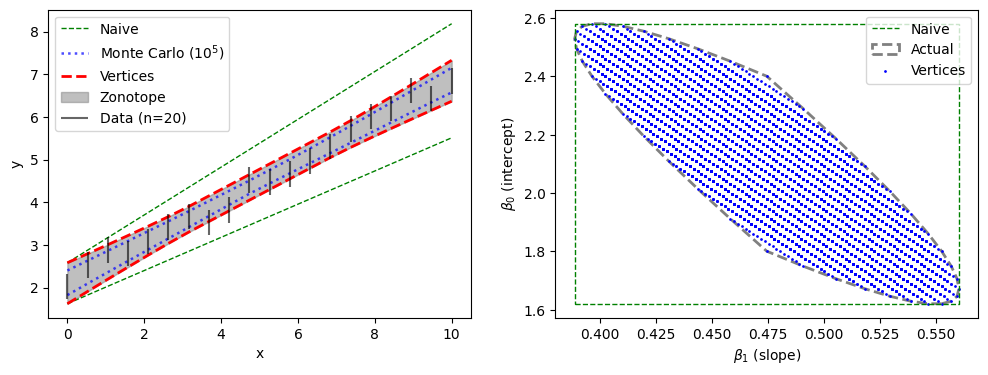

In [14]:
n, x, y, y_lower, y_upper, x_grid = linear_data(20)


beta_zono, (y_min, y_max) = zonotope_bounds(x, y_lower, y_upper, x_grid)
beta_naive, (naive_min, naive_max) = naive_bounds(x, y_lower, y_upper, x_grid)
_, (mc_min, mc_max) = monte_carlo_sampling(x, y_lower, y_upper, n_samples=100000, x_grid=x_grid)
beta_actual, (actual_min, actual_max) = actual_bounds(x, y_lower, y_upper, x_grid)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

ax = axes[0]

ax.plot(x_grid, naive_min, '--g', label='Naive', linewidth=1)
ax.plot(x_grid, naive_max, '--g', linewidth=1)

ax.plot(x_grid, mc_min, ':b', label=r'Monte Carlo ($10^{5}$)', linewidth=1.8, alpha=0.7)
ax.plot(x_grid, mc_max, ':b', linewidth=1.8, alpha=0.7)

ax.plot(x_grid, actual_min, '--r', label='Vertices', linewidth=2)
ax.plot(x_grid, actual_max, '--r', linewidth=2)

ax.fill_between(
    x_grid, y_max, y_min,
    color='gray', alpha=0.5, label='Zonotope'
)

ax.vlines(
    x_grid,
    y_lower.flatten(), y_upper.flatten(),
    color='black', alpha=0.6, label='Data (n=20)'
)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend()


ax = axes[1]

beta0_int, beta1_int = beta_naive
beta0_low, beta0_high = beta0_int[0][0], beta0_int[0][1]
beta1_low, beta1_high = beta1_int[0][0], beta1_int[0][1]

beta_actual = np.array(beta_actual)

ax.plot(
    [beta1_low, beta1_high, beta1_high, beta1_low, beta1_low],
    [beta0_low, beta0_low, beta0_high, beta0_high, beta0_low],
    linestyle='--',
    color='green',
    linewidth=1,
    label='Naive'
)

hull = ConvexHull(beta_actual)

ax.fill(
    beta_actual[hull.vertices, 1],
    beta_actual[hull.vertices, 0],
    fill=False,
    edgecolor="gray",
    linestyle="--",
    linewidth=2,
    label="Actual"
)

plt.scatter(beta_actual[:,1], beta_actual[:,0], color="blue", s=2,  linewidths=0.5, label="Vertices")

ax.set_xlabel(r"$\beta_1$ (slope)")
ax.set_ylabel(r"$\beta_0$ (intercept)")
ax.legend()

plt.show()


### Prediction Intervals and Confidence Bands

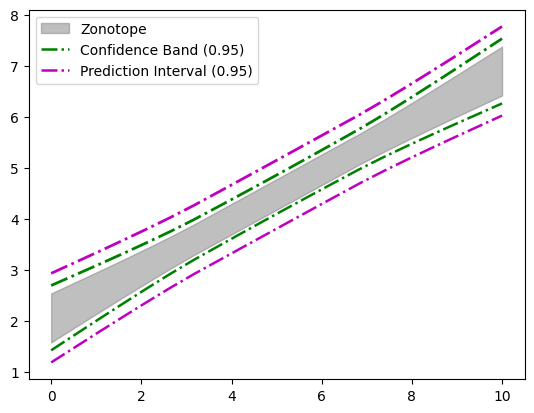

In [ ]:
def prediction_intervals(Phi, Phi_grid, PhiTPhi_inv, residuals, zono_lower, zono_upper, alpha=0.05):
    n, p = Phi.shape
    t_val = t.ppf(1 - alpha / 2, df=n - p)

    sigma2 = np.sum(residuals**2) / (n - p)
    sigma = np.sqrt(sigma2)

    quad_form = np.sum((Phi_grid @ PhiTPhi_inv) * Phi_grid, axis=1)
    SE_conf = sigma * np.sqrt(quad_form)
    SE_pred = sigma * np.sqrt(1.0 + quad_form)
    
    y_lower_PI = zono_lower - t_val * SE_pred
    y_upper_PI = zono_upper + t_val * SE_pred
    
    y_lower_CB = zono_lower - t_val * SE_conf
    y_upper_CB = zono_upper + t_val * SE_conf

    return (
        y_lower_CB,
        y_upper_CB,
        y_lower_PI,
        y_upper_PI
    )

def zonotope_bounds(X, y_lower, y_upper, x_grid=None):
    M = np.linalg.inv(X.T @ X) @ X.T

    centre_y = (y_lower + y_upper) / 2
    radii_y = (y_upper - y_lower) / 2
    G_y = np.diag(radii_y)
    Z_y = Zonotope(centre_y, G_y)

    Z_beta = Z_y.affine_map(M)

    beta_hat = M @ centre_y
    residuals = centre_y - X @ beta_hat

    if x_grid is None:
        return Z_beta


    y_min, y_max = [], []
    for xg in x_grid:
        Z_pred = Z_beta.affine_map(np.array([[1, xg]]))
        lower, upper = Z_pred.output_interval()
        y_min.append(lower[0])
        y_max.append(upper[0])

    Phi_grid = np.column_stack([np.ones(len(x_grid)), x_grid])

    y_lower_CB, y_upper_CB, y_lower_PI, y_upper_PI = prediction_intervals(
        Phi=X,
        Phi_grid=Phi_grid,
        PhiTPhi_inv=np.linalg.inv(X.T @ X),
        residuals=residuals,
        zono_lower=np.array(y_min),
        zono_upper=np.array(y_max),
        alpha=0.05
    )
    return (
        Z_beta,
        (np.array(y_min), np.array(y_max)),
        y_lower_CB,
        y_upper_CB,
        y_lower_PI,
        y_upper_PI
    )


   

n, x, y, y_lower, y_upper, x_grid = linear_data(20)


beta_zono, (y_min, y_max), y_lower_CB, y_upper_CB, y_lower_PI, y_upper_PI = zonotope_bounds(x, y_lower, y_upper, x_grid)


plt.fill_between(
    x_grid, y_max, y_min,
    color='gray', alpha=0.5, label='Zonotope'
)

plt.vlines(
    x_grid,
    y_lower.flatten(), y_upper.flatten(),
    color='black', alpha=0.6, label='Data (n=20)'
)

plt.plot(x_grid, y_lower_CB, '-.g', label='Confidence Band (0.95)', linewidth=1.8)
plt.plot(x_grid, y_upper_CB, '-.g', linewidth=2)

# Prediction intervals
plt.plot(x_grid, y_lower_PI, '-.m', label='Prediction Interval (0.95)', linewidth=1.8)
plt.plot(x_grid, y_upper_PI, '-.m', linewidth=2)

plt.legend()
plt.show()